&#x1f12f; Javier Bejar - APA/GEI/FIB/UPC

In [ ]:
# Uncomment to upgrade packages
# !pip3 install pandas --user --upgrade --quiet
# !pip3 install numpy --user --upgrade --quiet
# !pip3 install scipy --user --upgrade --quiet
# !pip3 install statsmodels --user --upgrade --quiet
# !pip3 install seaborn --user --upgrade --quiet
# !pip3 install matplotlib --user --upgrade --quiet
# !pip3 install scikit-learn --user --upgrade 
!pip install scikit-optimize --user --quiet
!pip install apafib --upgrade --user --quiet

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))

from time import time
from datetime import timedelta

init_time = time()

# APA - Laboratorio - Sesión 5
## K-nearest neighbours - Multi Layer Perceptron

In [2]:
import pandas as pd
from pandas import read_csv

import numpy as np
from numpy.random import choice
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import set_config

from sklearn.metrics import  ConfusionMatrixDisplay,\
                  classification_report,  RocCurveDisplay, PrecisionRecallDisplay,\
                    accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error

from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding

from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor


from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV,train_test_split, cross_val_score, TimeSeriesSplit

from yellowbrick.classifier.rocauc import roc_auc
from yellowbrick.target.feature_correlation import feature_correlation
from yellowbrick.classifier import precision_recall_curve

from apafib import load_electric_devices, load_energy

import warnings

set_config(display='text')
warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 16})
# sns.set()
pd.set_option('display.precision', 3)

In [3]:
def save_results(clf,  X_test, y_test, nclf, df):
    df.loc[nclf,'train XV acc'] = clf.best_score_
    df.loc[nclf,'test acc'] = accuracy_score(y_test, clf.predict(X_test))
    df.loc[nclf,'precision score (W)'] = precision_score(y_test, clf.predict(X_test), average='weighted')
    df.loc[nclf,'recall score (W)'] = recall_score(y_test, clf.predict(X_test), average='weighted')
    df.loc[nclf,'f1 score (W)'] = f1_score(y_test, clf.predict(X_test), average='weighted')
    return df

results_df = pd.DataFrame()

niter = 15
cv = 5

## Seccion 1: Electric Devices Consumption - Clasificación

Este conjunto de datos corresponde al patron de consumo de un dia (cada 15 minutos) de un conjunto de aparatos electrónicos comunes (7) en una casa. El objetivo es clasificar el patrón de consumo en el aparato correspondiente.

Este conjunto de datos solo tiene datos continuos, esto es más adecuado para estos dos modelos.


In [4]:
data = load_electric_devices()
data.head()

,Class,H00:00,H00:15,H00:30,H00:45,H01:00,H01:15,H01:30,H01:45,H02:00,...,H21:30,H21:45,H22:00,H22:15,H22:30,H22:45,H23:00,H23:15,H23:30,H23:45
0,0,-0.186,-0.186,-0.186,-0.186,-0.186,-0.186,-0.186,-0.186,-0.186,...,5.990,2.913,-0.186,-0.186,-0.186,-0.186,-0.186,-0.186,-0.186,-0.186
1,0,-0.177,-0.177,-0.177,-0.177,-0.177,-0.177,-0.177,-0.177,-0.177,...,0.192,6.477,1.645,-0.177,-0.177,-0.177,-0.177,-0.177,-0.177,-0.177
2,0,-0.214,-0.214,-0.214,-0.214,-0.214,-0.214,-0.214,-0.214,-0.214,...,-0.214,-0.214,-0.214,-0.214,-0.214,-0.214,-0.214,-0.214,-0.214,-0.214
3,0,-0.171,-0.171,-0.171,-0.171,-0.171,-0.171,-0.171,-0.171,-0.171,...,0.161,0.180,0.161,7.355,1.177,-0.171,-0.171,-0.171,-0.171,-0.171
4,0,-0.169,-0.169,-0.169,-0.169,-0.169,-0.169,-0.169,-0.169,-0.169,...,0.191,6.074,0.171,0.191,0.191,7.395,0.851,-0.169,-0.169,-0.169


In [5]:
data.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
Class,8926.0,2.789,1.737,0.000,1.000,3.000,4.000,6.000
H00:00,8926.0,-0.145,0.748,-7.835,-0.445,-0.226,-0.127,9.696
H00:15,8926.0,-0.167,0.696,-4.315,-0.452,-0.228,-0.134,9.459
H00:30,8926.0,-0.173,0.671,-3.446,-0.460,-0.230,-0.136,6.895
H00:45,8926.0,-0.179,0.661,-2.704,-0.456,-0.230,-0.138,9.696
...,...,...,...,...,...,...,...,...
H22:45,8926.0,0.142,1.137,-4.261,-0.346,-0.189,0.422,8.539
H23:00,8926.0,0.051,1.011,-4.725,-0.364,-0.198,0.156,9.665
H23:15,8926.0,-0.036,0.881,-5.499,-0.396,-0.207,-0.052,7.940
H23:30,8926.0,-0.093,0.848,-6.746,-0.433,-0.216,-0.102,8.751


Tenemos 7 clases con cierto imbalance entre ellas

In [6]:
data['Class'].value_counts()

Class
4    2406
1    2231
3    1474
2     851
6     728
0     727
5     509
Name: count, dtype: int64

In [7]:
cls = [str(v) for v in sorted(data['Class'].unique())]
cls

['0', '1', '2', '3', '4', '5', '6']

Podemos comprobar si tenemos datos perdidos

In [8]:
for c in data.columns:
    if data[c].isna().sum()>0:
        print(c, data[c].isna().sum())

Separamos la clase de los atributos y obtenemos el conjunto de entrenamiento y test de manera estratificada

In [9]:
X= data.iloc[:,1:]
y= data.loc[:,'Class']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

Es poco práctico el visualizar 96 atributos, podríamos comprobar las caracterísitcas de los atributos por ejemplo calculando test estadísticos sobre su distribución si queremos usar algún modelo que asuma alguna distribución a priori.


Podemos no obstante esperar cierta correlación entre instantes consecutivos

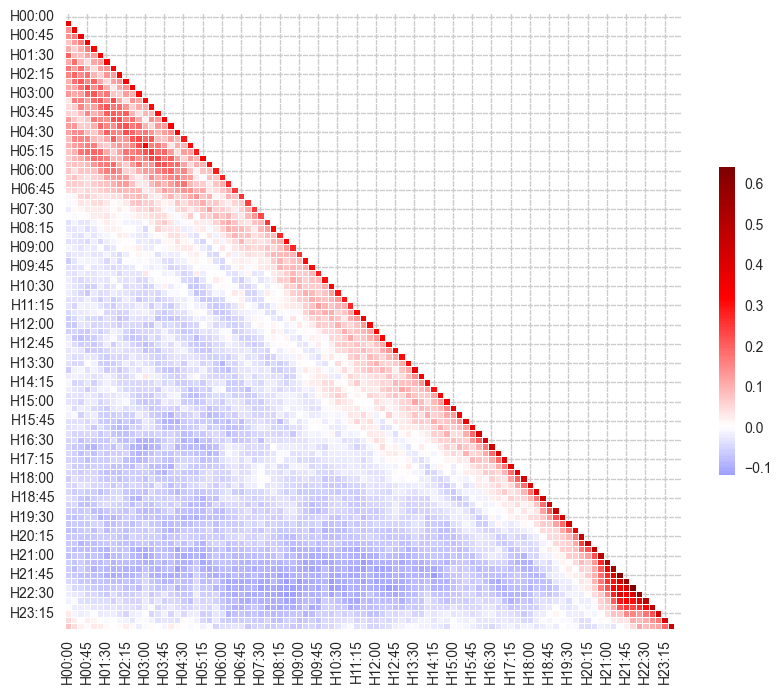

In [11]:
corr = X_train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=mask, cmap='seismic',  center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});


Para poder ver si hay alguna relación entre las variables y las clases podemos usar métodos de reducción de dimensionalidad, aplicaremos PCA en este caso. Primero estandarizaremos los datos

In [12]:
sscaler = StandardScaler()
X_train_sd = sscaler.fit_transform(X_train)
X_test_sd = sscaler.transform(X_test)

In [13]:
pca = PCA().fit(X_train_sd);

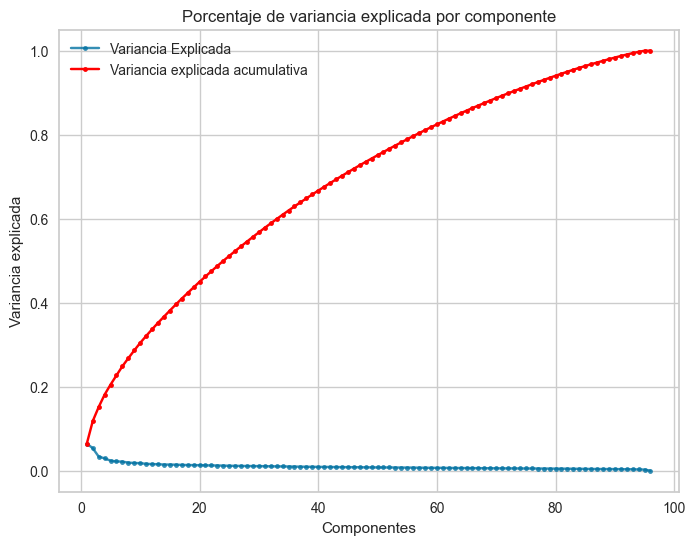

In [14]:
fig = plt.figure(figsize=(8,6));
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),pca.explained_variance_ratio_ ,alpha=0.8,marker='.',label="Variancia Explicada");
y_label = plt.ylabel('Variancia explicada');
x_label = plt.xlabel('Componentes');
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),
         np.cumsum(pca.explained_variance_ratio_),
         c='red',marker='.',
         label="Variancia explicada acumulativa");
plt.legend();
plt.title('Porcentaje de variancia explicada por componente');

Podemos ver que la variancia de los datos esta distribuida por todos los componentes asi que una visualizacion en dos dimensiones nos va a dar una visión limitada.

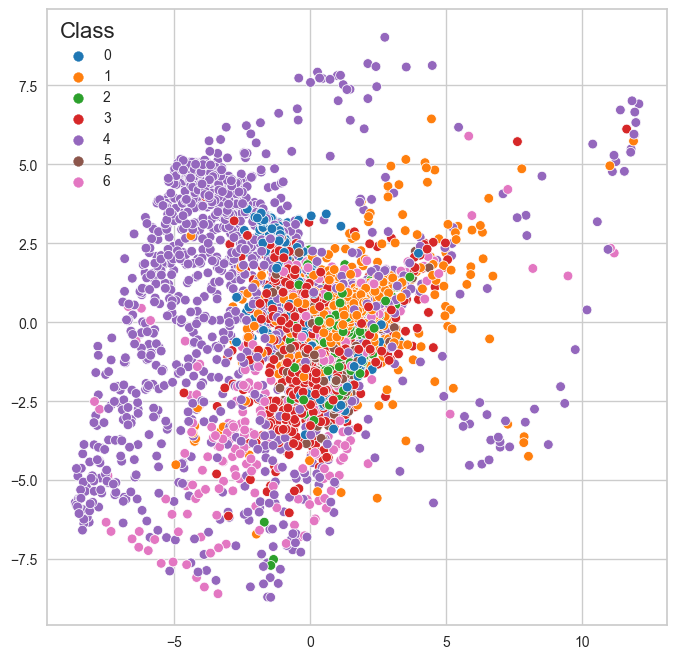

In [15]:
X_train_pca = pca.transform(X_train_sd)
X_test_pca = pca.transform(X_test_sd)
plt.figure(figsize=(8,8));
sns.scatterplot(x=X_train_pca[:,0], y=X_train_pca[:,1], hue=y_train, palette='tab10');

Aun así, podemos ver que hay cierta separabilidad entre las clases, aunque es dificil decir si todas son separables.

### K nearest neighbours

K-nn funciona a partir de la recuperación de los vecinos más cercanos a partir de su distancia, por lo que es importante que todos los atributos se encuenten en la misma escala asi que los normalizamos utilizando el MinMax scaler.

In [16]:
scaler = MinMaxScaler()

X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

Debemos explorar el rango de hperparámetos de K-nn, basicamente cuantos vecinos usamos para hacer la predicción, que distancias usamos para recuperarlos, como combinamos las distancias y cual es la resolución del indice que nos permite recuperar los vecinos (kd-tree).

In [17]:
knn =  KNeighborsClassifier()
param = {'n_neighbors':[1, 3, 5, 7, 11, 15], 
          'weights':['distance', 'uniform'], 
          'leaf_size':[1, 5, 10, 20, 30],
          'metric': ['l2', 'l1', 'cosine']}

knn_gs =  GridSearchCV(knn,param,cv=cv, n_jobs=-1)
knn_gs.fit(X_train_s, y_train);

In [18]:
show_html(pd.DataFrame(knn_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
54,"{'leaf_size': 5, 'metric': 'l1', 'n_neighbors': 7, 'weights': 'distance'}",0.735,1
126,"{'leaf_size': 20, 'metric': 'l1', 'n_neighbors': 7, 'weights': 'distance'}",0.735,1
18,"{'leaf_size': 1, 'metric': 'l1', 'n_neighbors': 7, 'weights': 'distance'}",0.735,1
90,"{'leaf_size': 10, 'metric': 'l1', 'n_neighbors': 7, 'weights': 'distance'}",0.735,1
162,"{'leaf_size': 30, 'metric': 'l1', 'n_neighbors': 7, 'weights': 'distance'}",0.735,1


Podemos ver que hay todo un conjuto de hiperparámetos que dan el mismo resutado (al menos al tercer decimal). Los resultados se ordenan lexicograficamente, por defecto la mejor solucion tendra un indice con un ejemplo por hoja. En un caso práctico, a igualdad de resultados, un indice con más ejemplos por hoja debería ser más rápido.

In [19]:
print(classification_report(knn_gs.predict(X_test_s), y_test,target_names=cls))
results_df = save_results(knn_gs, X_test_s, y_test, 'KNN', results_df)

              precision    recall  f1-score   support

           0       0.75      0.56      0.64       319
           1       0.95      0.95      0.95       731
           2       0.57      0.60      0.58       263
           3       0.70      0.57      0.63       596
           4       0.82      0.85      0.84       764
           5       0.34      0.45      0.39       126
           6       0.40      0.65      0.49       147

    accuracy                           0.74      2946
   macro avg       0.65      0.66      0.65      2946
weighted avg       0.76      0.74      0.74      2946



Podemos ver que el acierto en el test es consistente con la validación cruzada. No todas las clases tienen los mismos resultados, las ultimas dos son las que tienen peor resultado. Esto puede deberse básicamente a que no tienen una gran diferencia con el resto 

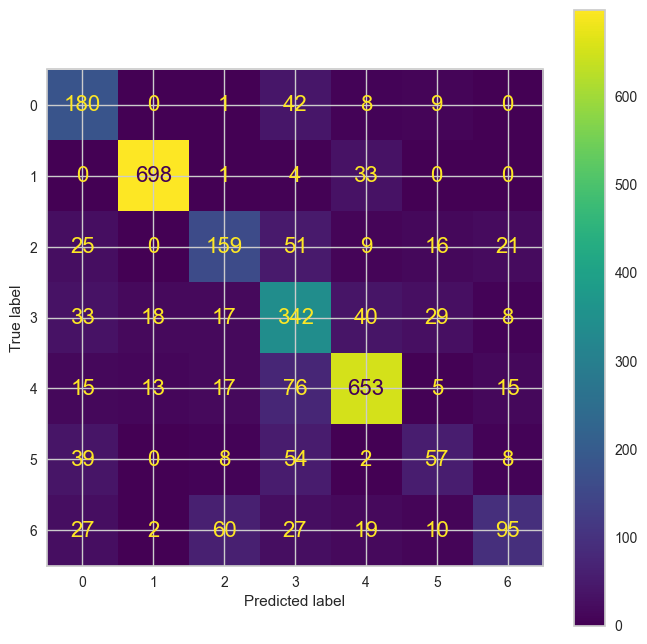

In [20]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(knn_gs, X_test_s,y_test, display_labels=cls, ax=plt.subplot());

Aqui podemos ver que hay clases que tienen bastante confusión con las clases que peor resultado tienen.

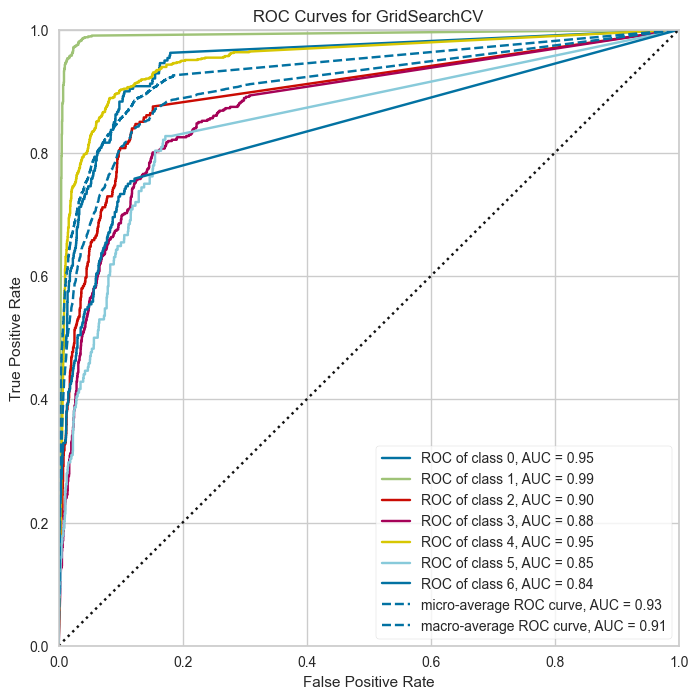

In [21]:
plt.figure(figsize=(8,8));
roc_auc(knn_gs, X_train_s, y_train, X_test_s, y_test, classes=cls);

Como vimos la ROC multiclase es más dificil de interpretar, pero podemos ver que hay una clase fácilmente separable del resto, el resto nos daran un relativamente alto porcentaje de falsos positivos (~20%) 

Podemos usar permutation importance para ver que atributos parecen más importantes para la clasificación. En este caso tenemos 96 atributos asi que reduciremos la muestra con la que se calcula.

In [22]:
c = choice(X_test.shape[0], size=1000, replace=False)
pi = permutation_importance(knn_gs,X_test_s[c], y_test.to_numpy()[c], n_jobs=-1, random_state=0)
var_imp_knn = pd.DataFrame({'importance': pi.importances_mean}, index=data.columns[1:])

Podemos ver que la importancia se distribuye entre bastantes horas, habría que interpretar si tiene sentido (de todas formas, hemos hecho el calculo con una submuestra pequeña, asi que no sería fiable el resultado)

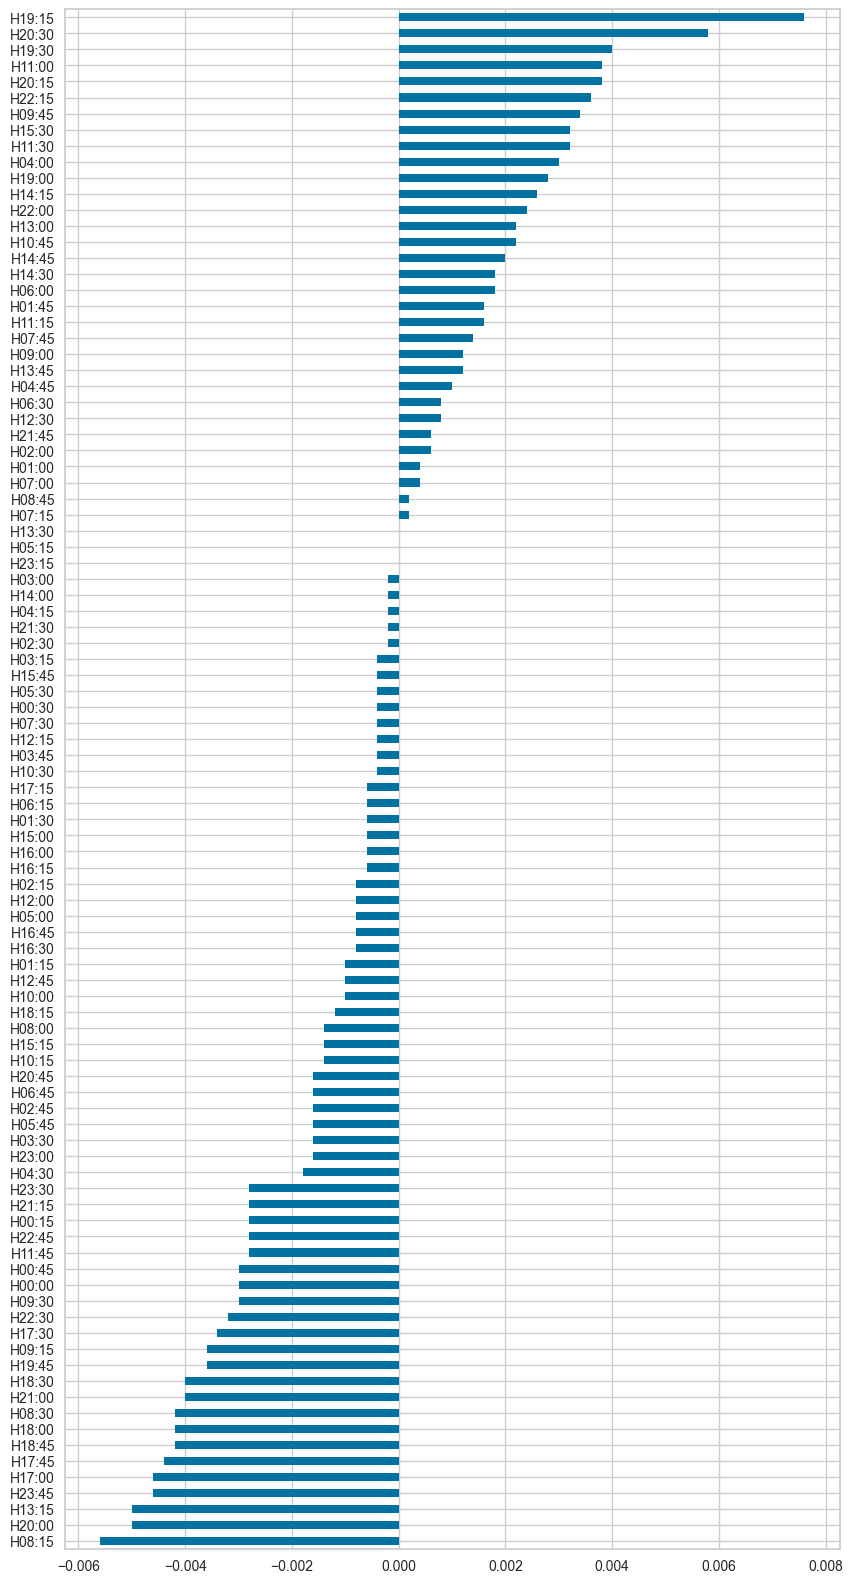

In [23]:
var_imp_knn.sort_values(by='importance').plot.barh(figsize=(10,20), legend=False);

Como vimos, K-nn tiene problemas cuando la dimensionalidad crece, en este caso podemos usar los componentes de PCA para reducir estas dimensiones y comprobar si podemos reducir el tamaño sin comprometer la calidad del resultado. 

En un caso práctico esto puede ayudarnos a reducir la memoria necesaria para almacenar el modelos (tenemos que guardar los datos originales para poder predecir)

In [24]:
nc = 40
X_train_pca_s = scaler.fit_transform(X_train_pca[:,:nc])
X_test_pca_s = scaler.transform(X_test_pca[:,:nc])

In [25]:
knn =  KNeighborsClassifier()
param = {'n_neighbors':[1, 3, 5, 7, 11, 15], 
          'weights':['distance', 'uniform'], 
          'leaf_size':[1, 5, 10, 20, 30],
          'metric': ['l2', 'l1', 'cosine']}

knn_gs =  GridSearchCV(knn,param,cv=cv, n_jobs=-1)
knn_gs.fit(X_train_pca_s, y_train);

In [26]:
show_html(pd.DataFrame(knn_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
150,"{'leaf_size': 30, 'metric': 'l2', 'n_neighbors': 7, 'weights': 'distance'}",0.711,1
114,"{'leaf_size': 20, 'metric': 'l2', 'n_neighbors': 7, 'weights': 'distance'}",0.711,1
42,"{'leaf_size': 5, 'metric': 'l2', 'n_neighbors': 7, 'weights': 'distance'}",0.711,1
6,"{'leaf_size': 1, 'metric': 'l2', 'n_neighbors': 7, 'weights': 'distance'}",0.711,1
78,"{'leaf_size': 10, 'metric': 'l2', 'n_neighbors': 7, 'weights': 'distance'}",0.711,1


Podemos ver que reducir alrededor de un 40% los atributos no reduce demasiado el error de crosvalidacion, habría que ver si compensa en la práctica o tiene sentido en la aplicación real.

In [27]:
print(classification_report(knn_gs.predict(X_test_pca_s), y_test,target_names=cls))
results_df = save_results(knn_gs, X_test_pca_s, y_test, 'KNN (PCA)', results_df)

              precision    recall  f1-score   support

           0       0.77      0.61      0.68       303
           1       0.91      0.83      0.87       808
           2       0.59      0.52      0.55       323
           3       0.63      0.59      0.61       521
           4       0.74      0.83      0.78       709
           5       0.30      0.37      0.33       134
           6       0.40      0.64      0.49       148

    accuracy                           0.70      2946
   macro avg       0.62      0.63      0.62      2946
weighted avg       0.72      0.70      0.71      2946



El error en el conjunto de test es coherente, pero hemos perdido calidad en la mejor clase.

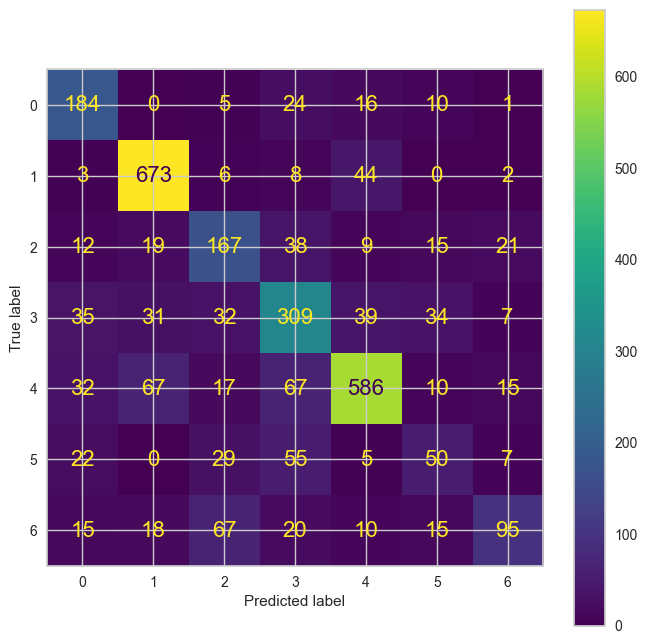

In [28]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(knn_gs, X_test_pca_s,y_test, display_labels=cls, ax=plt.subplot());

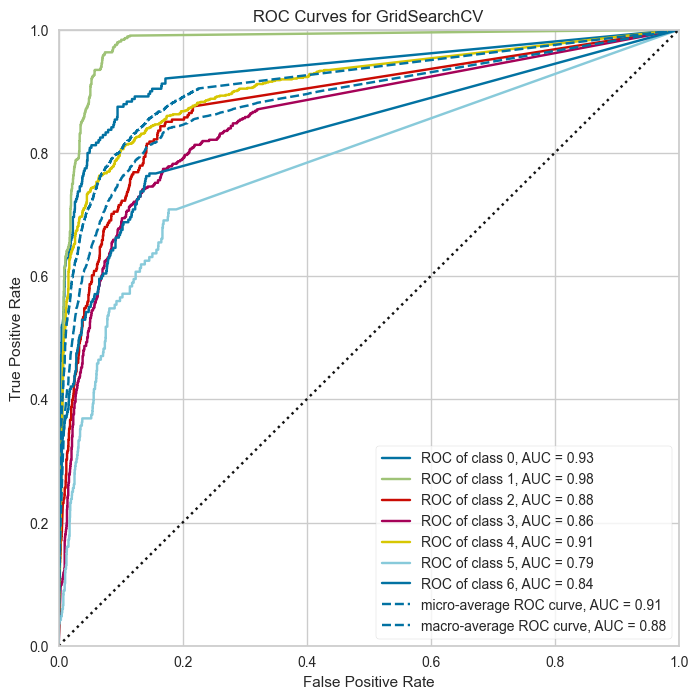

In [29]:
plt.figure(figsize=(8,8));
roc_auc(knn_gs, X_train_pca_s, y_train, X_test_pca_s, y_test, classes=cls);

## MLP

En el caso del MLP la forma en la que normalizamos los datos puede tener un impacto no solo en la calidad del resultado, sino tambien en la velocidad de convergencia. Usaremos el StandardScaler ya que converge más rápido, podeis cambiar vosotros la normalización para ver la diferencia.


In [30]:
sdscaler = StandardScaler()

X_train_sd = sdscaler.fit_transform(X_train)
X_test_sd = sdscaler.transform(X_test)

El permitir early stopping reducira el tiempo de ajuste, es probable que el resultado sea algo peor a veces, pero reducimos la posibilidad de sobre ajuste.

In [31]:
mlp = MLPClassifier(max_iter=10000, early_stopping=True, n_iter_no_change=15, random_state=0)

Los parametros por defecto dan un resultado parecido al Knn.

Haremos primero una exploración en cuadrícula probando algunos valores para los hiperparámetros.

In [32]:
param = {'hidden_layer_sizes':[10, 50, 100, 200], 
         'activation':['relu', 'logistic', 'identity'], 
         'learning_rate_init': [0.001, 0.01, 0.1]  }

mlp =  MLPClassifier(max_iter=10000, early_stopping=True, n_iter_no_change=20,learning_rate='adaptive',random_state=0)
mlp_gs = GridSearchCV(mlp,param,cv=cv, n_jobs=-1, refit=True)
mlp_gs.fit(X_train_sd, y_train);

In [33]:
show_html(pd.DataFrame(mlp_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
21,"{'activation': 'logistic', 'hidden_layer_sizes': 200, 'learning_rate_init': 0.001}",0.712,1
9,"{'activation': 'relu', 'hidden_layer_sizes': 200, 'learning_rate_init': 0.001}",0.708,2
18,"{'activation': 'logistic', 'hidden_layer_sizes': 100, 'learning_rate_init': 0.001}",0.708,3
22,"{'activation': 'logistic', 'hidden_layer_sizes': 200, 'learning_rate_init': 0.01}",0.708,4
10,"{'activation': 'relu', 'hidden_layer_sizes': 200, 'learning_rate_init': 0.01}",0.701,5


Obtenemos un resultado algo peor. No podemos explorar completamente el espacio de hiperparámetros debido al coste de ajustar cada modelo.

Una alternativa es utilizar una exploración aleatoria o dirigida de alguna manera pero no explorando todas las posibilidades. Un método que permite una buena exploración es la búsqueda bayesiana. En esta vamos muestreando el espacio de hiperparámetros y obteniendo una función substituto que aproxima la calidad del resultado para todo el espacio de valores de manera que podemos ir escogiendo combinaciones dependiendo de la calidad  que  estime esta función.

In [35]:
from skopt import BayesSearchCV
np.int = int # Workaround for bug in skopt

In [36]:
niter = 15
param = {'hidden_layer_sizes':[10, 50, 100, 200, 300], 
'activation':['relu', 'identity', 'logistic'], 
'alpha':[0.0001, 0.001, 0.01],
'momentum': [0.95, 0.90, 0.85, 0.8], 
'learning_rate_init': [0.001, 0.01, 0.1],
'n_iter_no_change':[10, 20, 40, 50], 
'learning_rate': ['constant', 'invscaling', 'adaptive']}

mlp =  MLPClassifier(max_iter=10000,early_stopping=True,random_state=0)
mlp_bs =  BayesSearchCV(mlp,param,
                        n_iter=niter, 
                        cv=cv, n_jobs=-1, 
                        refit=True,random_state=0)
mlp_bs.fit(X_train_sd, y_train);

In [37]:
show_html(pd.DataFrame(mlp_bs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
1,"{'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': 300, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'momentum': 0.8, 'n_iter_no_change': 40}",0.711,1
11,"{'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': 200, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'momentum': 0.85, 'n_iter_no_change': 10}",0.707,2
5,"{'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': 200, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'momentum': 0.85, 'n_iter_no_change': 50}",0.705,3
7,"{'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': 200, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'momentum': 0.85, 'n_iter_no_change': 10}",0.705,4
6,"{'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': 100, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'momentum': 0.95, 'n_iter_no_change': 20}",0.700,5


Dado que hay aleatoriedad en la búsqueda el resultado puede variar entre ejecuciones, pero podemos limitar el numero de ajustes del modelo y explorarlo más.

In [38]:
print(classification_report(mlp_gs.predict(X_test_sd), y_test,target_names=cls))
results_df = save_results(mlp_gs, X_test_sd, y_test, 'MLP', results_df)

              precision    recall  f1-score   support

           0       0.64      0.70      0.67       218
           1       0.92      0.88      0.90       771
           2       0.65      0.63      0.64       288
           3       0.68      0.61      0.64       542
           4       0.78      0.81      0.79       759
           5       0.32      0.36      0.34       146
           6       0.49      0.53      0.51       222

    accuracy                           0.72      2946
   macro avg       0.64      0.65      0.64      2946
weighted avg       0.73      0.72      0.72      2946



El error del test es coherente con el de validacion cruzada. El resultado es algo diferente, hemos mejorado en alguna de las clases peores.

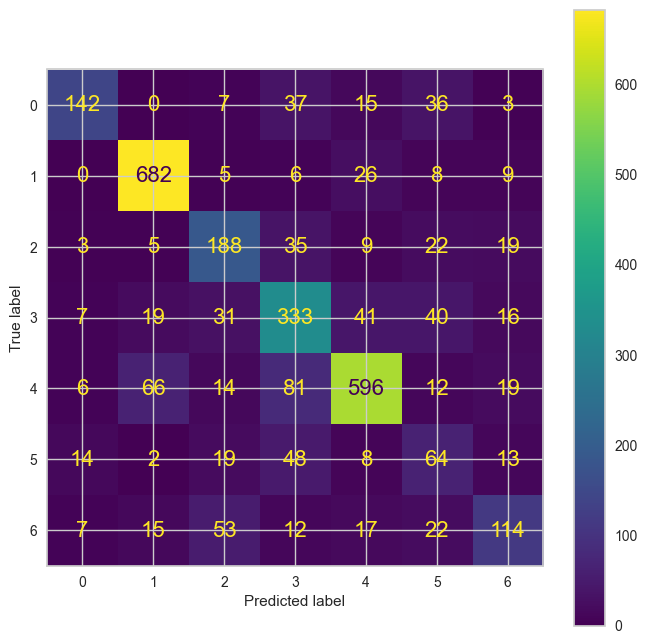

In [39]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(mlp_bs, X_test_sd,y_test, display_labels=cls, ax=plt.subplot());

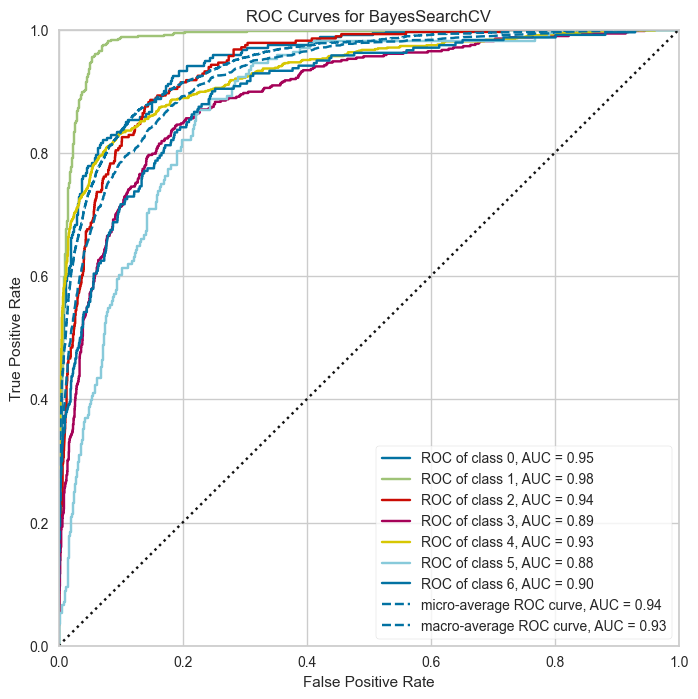

In [40]:
plt.figure(figsize=(8,8));
roc_auc(mlp_bs, X_train_sd, y_train, X_test_sd, y_test, classes=cls);

El resultado de ese modelo es bastante parecido

In [41]:
c = choice(X_test.shape[0], size=2000, replace=False)
pi = permutation_importance(mlp_gs,X_test_sd[c], y_test.to_numpy()[c], n_jobs=-1, random_state=0)
var_imp_mlp = pd.DataFrame({'importance': pi.importances_mean},
                       index=data.columns[1:])

La importancia de los atributos es diferente, pero podemos mirar qué es común entre los dos modelos

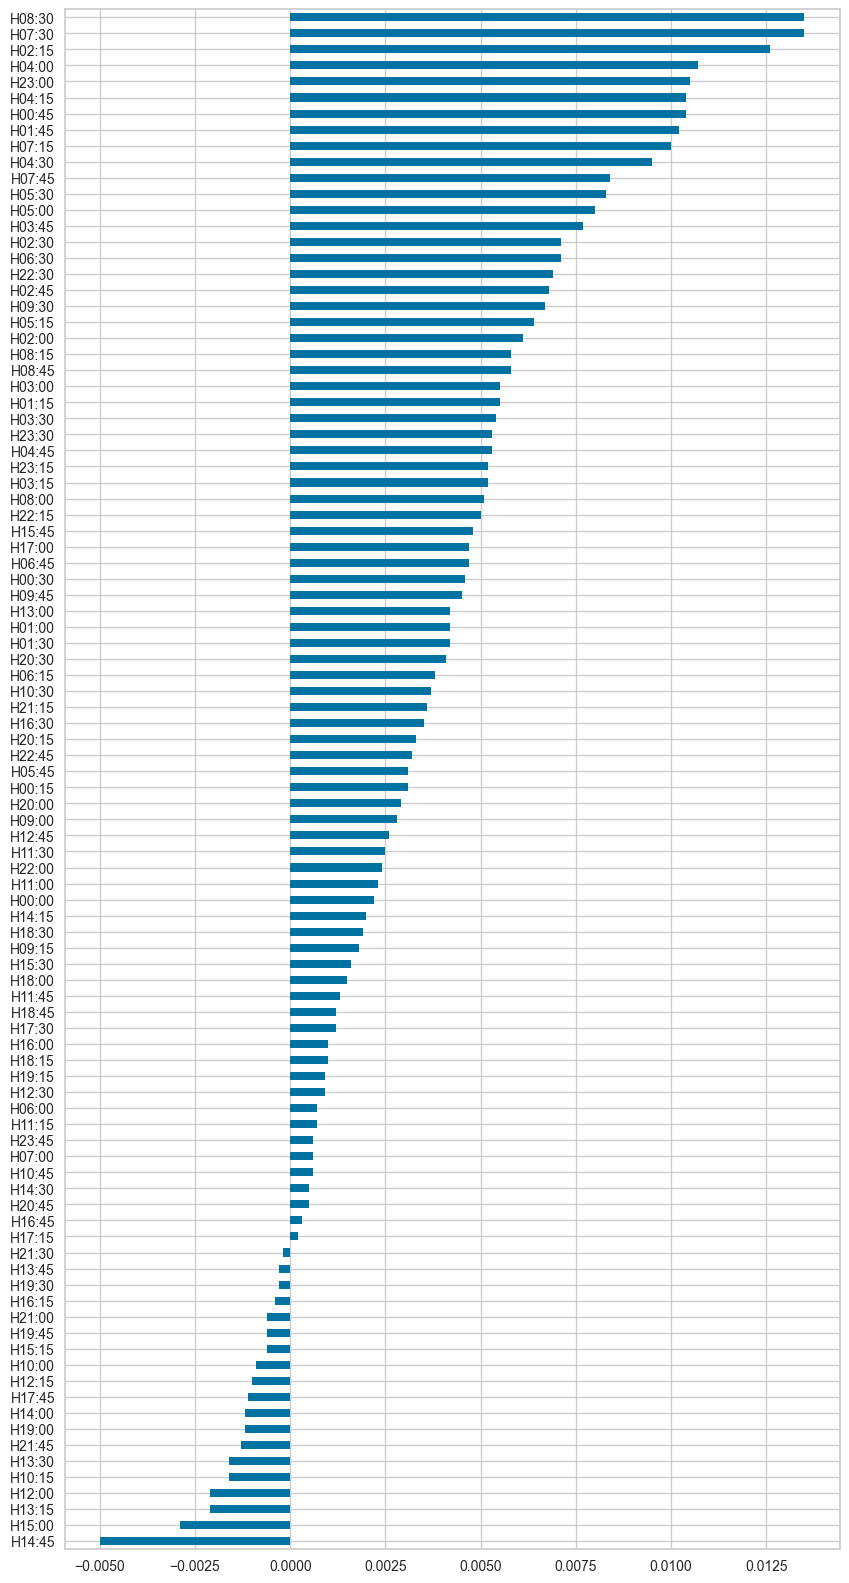

In [42]:
var_imp_mlp.sort_values(by='importance').plot.barh(figsize=(10,20), legend=False);

Podemos comparar las importancias que asignan a los atributos los modelos, pero que tienen principios muy diferentes pueden no coindicir demasiado en que importancia les asignan

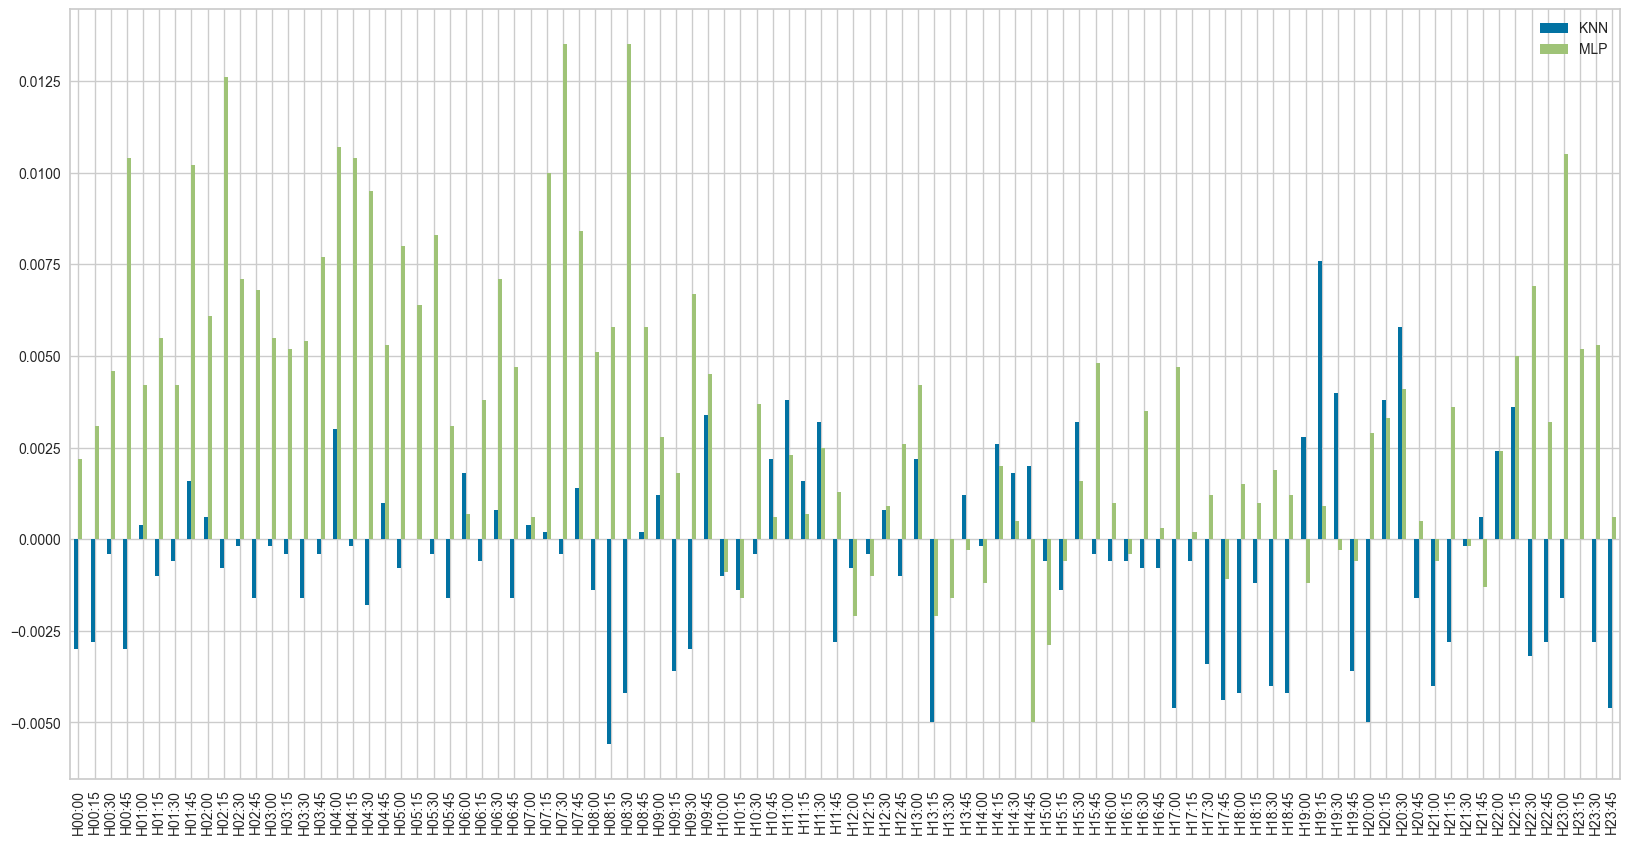

In [47]:
importances = pd.concat([var_imp_knn, var_imp_mlp], axis=1)
importances.columns = ['KNN', 'MLP']
importances.plot.bar(figsize=(20,10));

Ahora podemos ver los resultados de la validación cruzada y comparar los resultados sobre la particion de test

In [44]:
results_df.sort_values(by=['test acc'], ascending=False)

,train XV acc,test acc,precision score (W),recall score (W),f1 score (W)
KNN,0.735,0.741,0.746,0.741,0.738
MLP,0.712,0.722,0.720,0.722,0.720
KNN (PCA),0.711,0.701,0.701,0.701,0.696


## Sección 2: Energy Data - Regresión

Un problema que se puede resolver mediante regresión es la predicción de series de tiempo.

La predicción de series temporales es un mundo en si mismo, pero también podemos usar modelos de aprendizaje para esta tarea. 

En este tipo de problemas queremos predecir valores de un momento en el tiempo a partir de los valores anteriores. En este caso debemos decidir cuantos instantes anteriores utilizamos y si utilizamos solo la variable objetivo o añadimos también otras variables que tengamos disponibles.

En este caso usaremos un conjunto de datos parecido al de clasificación, queremos predecir el consumo de energia de los electrodomesticos de una casa. Tenemos muchos otros atributos, pero en este caso solo utilizaremos la variable objetivo. Podéis encontrar la documentación de este conjunto de datos aqui (https://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction)


In [50]:
data = load_energy()

niter = 15
cv = 5

In [57]:
data.head()


,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,11-01-2016 17:00,60,30,19.89,47.597,19.2,44.790,19.79,44.730,19.000,...,17.033,45.53,6.60,733.5,92.0,7.000,63.000,5.3,13.275,13.275
1,11-01-2016 17:10,60,30,19.89,46.693,19.2,44.722,19.79,44.790,19.000,...,17.067,45.56,6.48,733.6,92.0,6.667,59.167,5.2,18.606,18.606
2,11-01-2016 17:20,50,30,19.89,46.300,19.2,44.627,19.79,44.933,18.927,...,17.000,45.50,6.37,733.7,92.0,6.333,55.333,5.1,28.643,28.643
3,11-01-2016 17:30,50,40,19.89,46.067,19.2,44.590,19.79,45.000,18.890,...,17.000,45.40,6.25,733.8,92.0,6.000,51.500,5.0,45.410,45.410
4,11-01-2016 17:40,60,40,19.89,46.333,19.2,44.530,19.79,45.000,18.890,...,17.000,45.40,6.13,733.9,92.0,5.667,47.667,4.9,10.084,10.084


(19735, 29)

In [52]:
data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
date,19735,19735,11-01-2016 17:00,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Appliances,19735.0,NaN,NaN,NaN,97.695,102.525,10.0,50.0,60.0,100.0,1080.0
lights,19735.0,NaN,NaN,NaN,3.802,7.936,0.0,0.0,0.0,0.0,70.0
T1,19735.0,NaN,NaN,NaN,21.687,1.606,16.79,20.76,21.6,22.6,26.26
RH_1,19735.0,NaN,NaN,NaN,40.26,3.979,27.023,37.333,39.657,43.067,63.36
T2,19735.0,NaN,NaN,NaN,20.341,2.193,16.1,18.79,20.0,21.5,29.857
RH_2,19735.0,NaN,NaN,NaN,40.42,4.07,20.463,37.9,40.5,43.26,56.027
T3,19735.0,NaN,NaN,NaN,22.268,2.006,17.2,20.79,22.1,23.29,29.236
RH_3,19735.0,NaN,NaN,NaN,39.243,3.255,28.767,36.9,38.53,41.76,50.163
T4,19735.0,NaN,NaN,NaN,20.855,2.043,15.1,19.53,20.667,22.1,26.2


Seleccionamos la variable que queremos predecir.

In [53]:
energy = data.loc[:,'Appliances']

In [54]:
energy.describe()

count    19735.000
mean        97.695
std        102.525
min         10.000
25%         50.000
50%         60.000
75%        100.000
max       1080.000
Name: Appliances, dtype: float64

Seleccionamos un conjunto de entrenamiento (los 12000 primeros ejemplos) y de test (el resto).

En este tipo de problemas no podemos hacer la partición del conjunto de datos como en el resto de problemas que hemos tratado. Fijaos que los datos no son iid. Ademas si partieramos aleatoriamente el conjunto de datos estariamos mezclando instantes en el tiempo, lo que nos interesa es poder ajustar el modelo con los datos del pasado y predecir los futuros.

In [55]:
e_train, e_test =  energy.iloc[:12000], energy.iloc[12000:]

In [56]:
e_train.shape, e_test.shape

((12000,), (7735,))

Para generar el conjunto de datos debemos generar una matriz de datos en la que tengamos ventanas de la serie.

Para ello tenemos una función de numpy que tiene ese proposito.

In [58]:
from numpy.lib.stride_tricks import sliding_window_view

Seleccionamos un tamaño de ventana para hacer la matriz de datos. Usamos un tamaño w+1, asi tenemos la ventana anterior al dato a predecir en las primeras w posiciones y el dato a predecir en la última. 

La función que genera las ventanas nos retornará una matriz 3D, donde una de las dimensiones es una sola columna, la función `squeeze` nos elimina la columna redundante.

Generamos la matriz de datos para el conjunto de entrenamiento y el de test.

Normalizaremos primero los datos. Para Knn no deberia importar ya que todos los atributos se encuentran en el mismo rango, para MLP puede ayudar la convergencia ya que los datos estan en un rango de valores muy grande,

In [59]:
w = 4

sdscaler = MinMaxScaler()

e_train_s = sdscaler.fit_transform(e_train.to_numpy().reshape(-1, 1))
e_test_s = sdscaler.transform(e_test.to_numpy().reshape(-1, 1))

windows_train = sliding_window_view(e_train_s, w+1, axis=0).copy()
X_train_w, y_train_w = windows_train.squeeze()[:,:-1], windows_train.squeeze()[:,-1]

windows_test = sliding_window_view(e_test_s, w+1, axis=0).copy()
X_test_w, y_test_w = windows_test.squeeze()[:,:-1], windows_test.squeeze()[:,-1]

In [60]:
X_train_w.shape, X_test_w.shape, y_train_w.shape, y_test_w.shape

((11996, 4), (7731, 4), (11996,), (7731,))

### K nearest neighbours

El escalado de los datos en este caso sería innecesario ya que estamos utilizando la misma variable para generar todas las ventanas, asi que todas estarán un mismo rango. En todo caso normalizaríamos la variable antes de generar las ventanas.

En este caso usamos Knn para regresión y exploramos el rango de hiper parámetros. 

Igual que no podemos mezclar el tiempo en los datos de entrenamiento y test, la validacion cruzada tampoco se puede realizar de la misma manera, nos hemos de asegurar de que la particion de entrenamiento siempre este en el pasado y la de validacion en el futuro y que no compartan ventanas de datos entre ellas. Esto nos lo permite TimeSeriesSplit. La medida que usamos para elegir el modelo es MSE.

In [61]:
pd.set_option('display.precision', 5)
knn =  KNeighborsRegressor()

In [62]:
param = {'n_neighbors':[1, 3, 5, 7, 11, 15, 20, 25], 
         'weights':['distance', 'uniform'], 
         'leaf_size':[1, 5, 10, 15, 20, 25, 30],
         'metric': ['l2', 'l1', 'cosine']}

knn_bs = BayesSearchCV(knn,param,n_iter=niter, 
                        cv=TimeSeriesSplit(n_splits=cv, gap=w+1), 
                        scoring=make_scorer(mean_squared_error, greater_is_better=False),
                        n_jobs=-1, 
                        refit=True, random_state=0)         
knn_bs.fit(X_train_w, y_train_w);

In [63]:
show_html(pd.DataFrame(knn_bs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
8,"{'leaf_size': 5, 'metric': 'l2', 'n_neighbors': 20, 'weights': 'uniform'}",-0.00371,1
1,"{'leaf_size': 10, 'metric': 'l2', 'n_neighbors': 20, 'weights': 'uniform'}",-0.00371,2
0,"{'leaf_size': 15, 'metric': 'l1', 'n_neighbors': 11, 'weights': 'uniform'}",-0.00387,3
12,"{'leaf_size': 5, 'metric': 'l1', 'n_neighbors': 7, 'weights': 'uniform'}",-0.00395,4
14,"{'leaf_size': 5, 'metric': 'l1', 'n_neighbors': 20, 'weights': 'distance'}",-0.00409,5


El error de MSE no esta en las unidades de los datos, calcular la raiz cuadrada del error nos pondrá en esas unidades.

In [64]:
mean_squared_error(y_test_w,knn_bs.predict(X_test_w)), mean_absolute_error(y_test_w,knn_bs.predict(X_test_w))

(0.0034309441219635456, 0.026002306529000253)

El error en el test es parecido al de validacion cruzada (incluso algo mejor).

Podemos visualizar la predicción de los primeros datos del conjunto de test para ver como de cerca esta la prediccion del modelo de la realidad. **No es un metodo de validacion**, pero al menos nos permitirá ver si realmente estamos prediciendo algo.

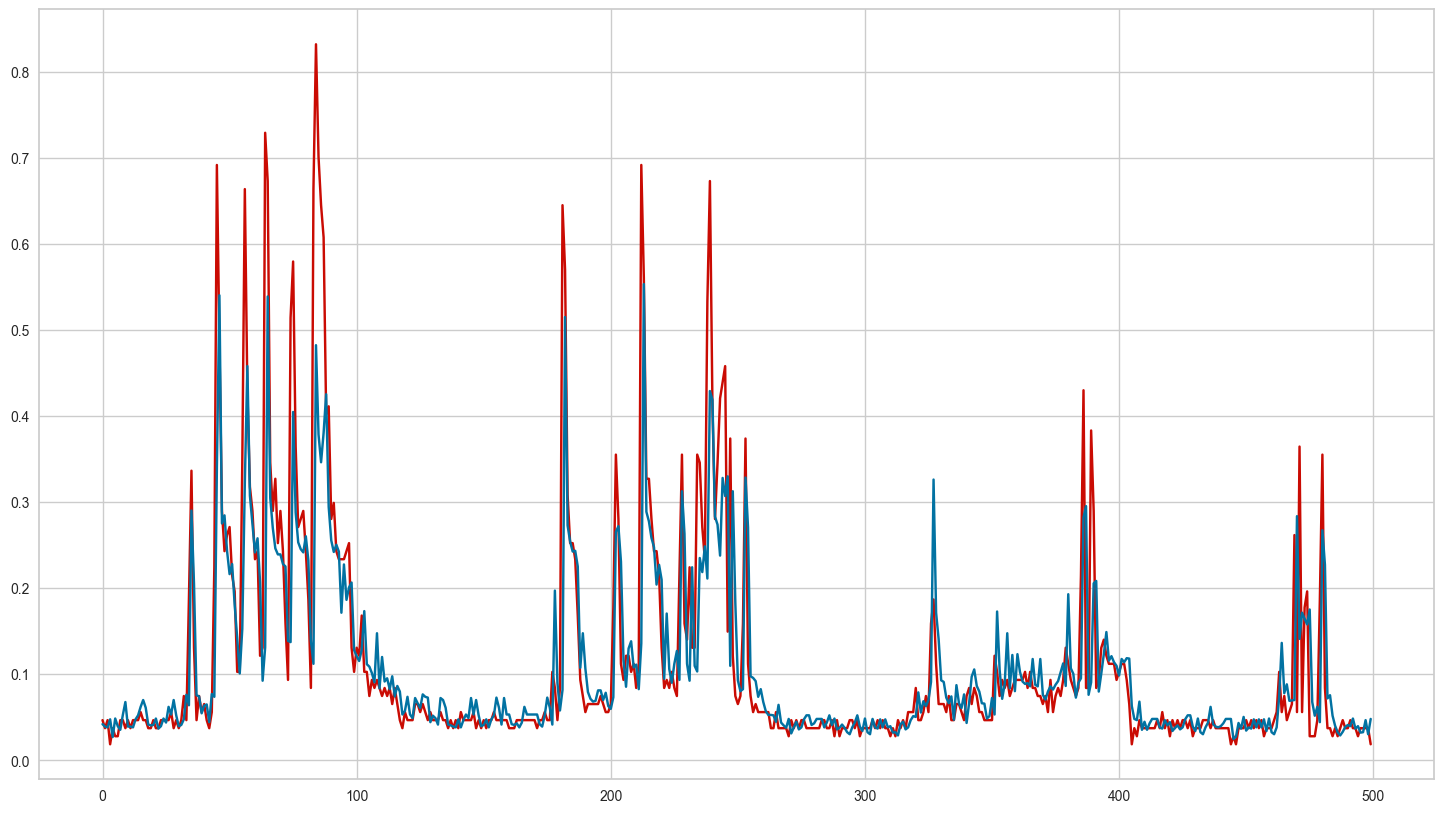

In [65]:
plt.figure(figsize=(18,10))
plt.plot(y_test_w[:500],'r');
plt.plot(knn_bs.predict(X_test_w[:500,:]),'b');

Podemos ver que la predicción sigue hasta cierto punto el principio de la serie del conjunto de test.

### MLP

Ahora usamos el MLP para regresión.

Exploramos los diferentes hiperparámetros del MLP, en este caso hacemos directamente una búsqueda bayesiana.

In [66]:
param = {'hidden_layer_sizes':[100, 200, 300], 
         'activation':['relu',  'logistic'], 
         'alpha':[0.0001, 0.001, 0.01],
         'momentum': [0.95, 0.90, 0.85], 
         'learning_rate_init': [0.001, 0.01, 0.1],
         'n_iter_no_change':[30, 40, 50], 
         'learning_rate': ['constant', 'invscaling', 'adaptive']}

mlp =  MLPRegressor(max_iter=10000,early_stopping=True,random_state=0)
mlp_bs = BayesSearchCV(mlp,param,n_iter=niter, 
                        cv=TimeSeriesSplit(n_splits=cv, gap=w+1), 
                        scoring=make_scorer(mean_squared_error, greater_is_better=False),
                        n_jobs=-1, 
                        refit=True, random_state=0)    
mlp_bs.fit(X_train_w, y_train_w);

In [67]:
show_html(pd.DataFrame(mlp_bs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
12,"{'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': 300, 'learning_rate': 'invscaling', 'learning_rate_init': 0.01, 'momentum': 0.9, 'n_iter_no_change': 40}",-0.00373,1
7,"{'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': 200, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'momentum': 0.85, 'n_iter_no_change': 30}",-0.00374,2
2,"{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': 200, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'momentum': 0.9, 'n_iter_no_change': 40}",-0.00374,3
6,"{'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': 200, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'momentum': 0.95, 'n_iter_no_change': 40}",-0.00374,4
10,"{'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': 100, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'momentum': 0.9, 'n_iter_no_change': 40}",-0.00376,5


In [68]:
mean_squared_error(y_test_w,mlp_bs.predict(X_test_w)), mean_absolute_error(y_test_w,mlp_bs.predict(X_test_w))

(0.0034332885703717746, 0.02539865468193313)

El MSE es coherente con el error de validación cruzada y es posiblemente ligeramente mejor que el de KNN, pero cada vez que ajustemos el MLP obtendremos un error diferente.

Podemos tambien superponer las predicciones del test sobre el valor real (**no es un método de validación**).

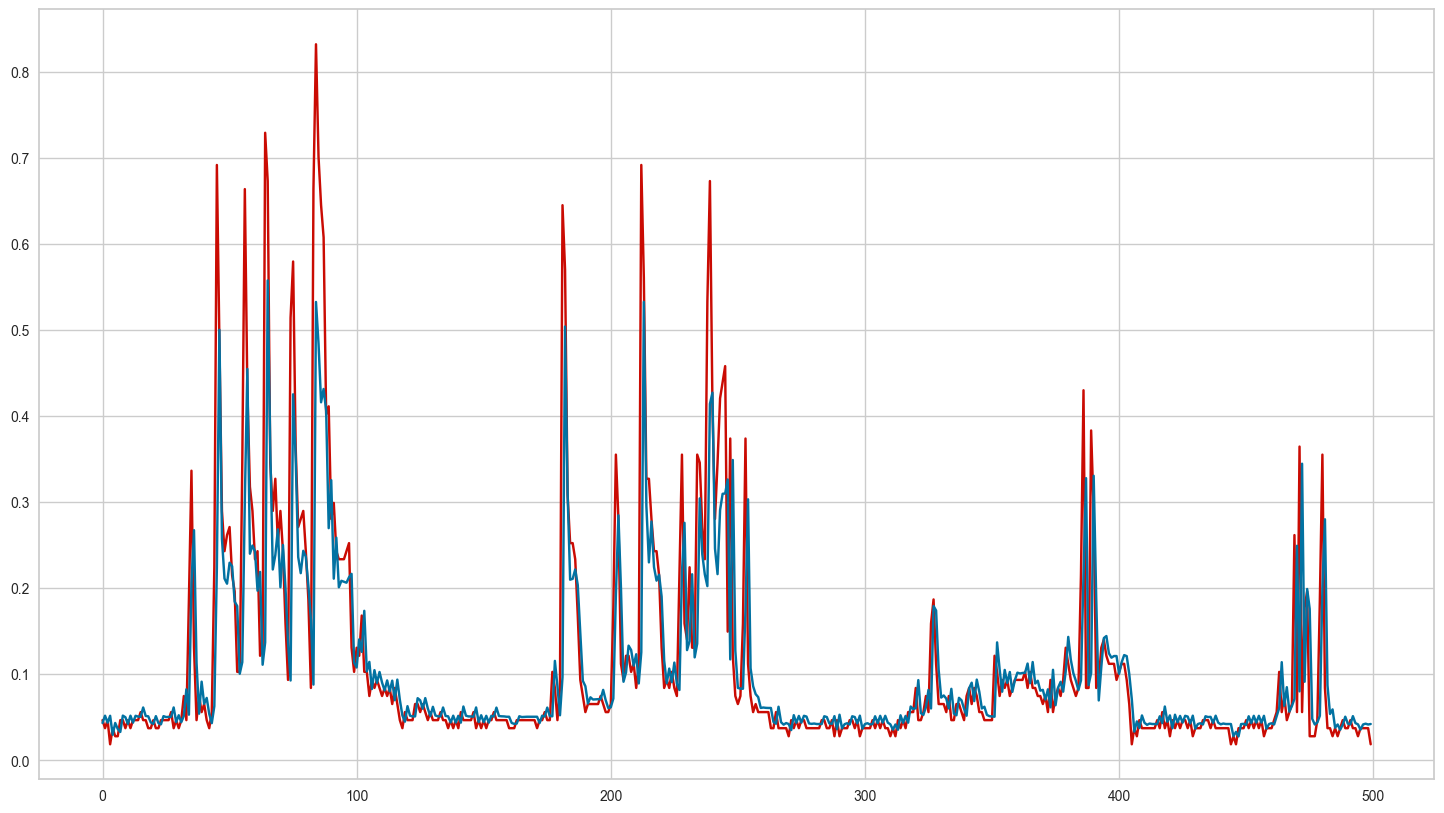

In [69]:
plt.figure(figsize=(18,10))
plt.plot(y_test_w[:500],'r');
plt.plot(mlp_bs.predict(X_test_w[:500,:]),'b');

Deberíamos explorar diferentes longitudes de ventana para ver cual es la que obtiene el mejor error, en este tipo de problemas este valor es otro hiperparámetro.

In [70]:
print(f"Total Running time {timedelta(seconds=(time() - init_time))}")

Total Running time 1:19:30.436230
